# Debug GM model 

In [1]:
import pandas as pd
import pyfaidx
import pyBigWig
import sklearn.metrics
import numpy as np
import matplotlib.pyplot as plt
import scipy
from collections import Counter
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
import sys
sys.path.append("/users/surag/kundajelab/chrombpnet-lite/src/")
from utils import data_utils, one_hot

In [3]:
def softmax(x):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(norm_x)/np.sum(np.exp(norm_x), axis=1, keepdims=True)

In [6]:
import tensorflow as tf
import keras
model = keras.models.load_model('my_model.h5', custom_objects={'tf': tf})

In [24]:
gm_fold1_bias_model = tf.keras.models.load_model("/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/folds/ATAC/GM12878/GM12878_07.08.2022_bias_128_4_1234_0.4_fold_1_data_type_ATAC_PE_try_2/chrombpnet_model/bias_model_scaled.h5",
                                compile=False,  custom_objects={'tf': tf})
gm_fold1_cbp_w_bias_model = tf.keras.models.load_model("/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/folds/ATAC/GM12878/GM12878_07.08.2022_bias_128_4_1234_0.4_fold_1_data_type_ATAC_PE_try_2/chrombpnet_model/chrombpnet.h5",
                                compile=False,  custom_objects={'tf': tf})
gm_fold1_cbp_wo_bias_model = tf.keras.models.load_model("/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/folds/ATAC/GM12878/GM12878_07.08.2022_bias_128_4_1234_0.4_fold_1_data_type_ATAC_PE_try_2/chrombpnet_model/chrombpnet_wo_bias.h5",
                                compile=False,  custom_objects={'tf': tf})

/users/anusri/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning:  is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [38]:
other_bias_model = tf.keras.models.load_model("/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/folds/ATAC/GM12878/GM12878_07.14.2022_bias_128_4_1234_0.4_fold_2_data_type_ATAC_PE/chrombpnet_model/bias_model_scaled.h5",
                                compile=False,  custom_objects={'tf': tf})
other_cbp_w_bias_model = tf.keras.models.load_model("/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/folds/ATAC/GM12878/GM12878_07.14.2022_bias_128_4_1234_0.4_fold_2_data_type_ATAC_PE/chrombpnet_model/chrombpnet.h5",
                                compile=False,  custom_objects={'tf': tf})
other_cbp_wo_bias_model = tf.keras.models.load_model("/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/folds/ATAC/GM12878/GM12878_07.14.2022_bias_128_4_1234_0.4_fold_2_data_type_ATAC_PE/chrombpnet_model/chrombpnet_wo_bias.h5",
                                compile=False,  custom_objects={'tf': tf})

OSError: SavedModel file does not exist at: /oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/folds/ATAC/GM12878/GM12878_07.14.2022_bias_128_4_1234_0.4_fold_2_data_type_ATAC_PE/chrombpnet_model/bias_model_scaled.h5/{saved_model.pbtxt|saved_model.pb}

In [39]:
gm_fold1_cbp_wo_bias_model.input_shape, gm_fold1_cbp_wo_bias_model.output_shape

((None, 2114, 4), [(None, 1000), (None, 1)])

In [40]:
INP_LEN = gm_fold1_cbp_wo_bias_model.input_shape[1]
OUT_LEN = gm_fold1_cbp_wo_bias_model.output_shape[0][1]
INP_LEN, OUT_LEN

(2114, 1000)

In [41]:
hg38 = pyfaidx.Fasta("/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta")

In [42]:
regions = pd.read_csv("/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/ATAC/GM12878/GM12878.interpreted_regions.sorted.bed.gz",
                      sep='\t',
                     names=['chr','start','end','x1','x2','x3','x4','x5','x6', 'summit'])
regions.head()

,chr,start,end,x1,x2,x3,x4,x5,x6,summit
0,chr1,9950,10279,Peak_220339,282,.,3.44359,28.22707,26.44250,102
1,chr1,778328,779291,Peak_10908,1000,.,20.10530,1455.80566,1452.52356,339
2,chr1,778328,779291,Peak_254156,196,.,2.16906,19.65923,17.94029,75
3,chr1,778328,779291,Peak_5531,1000,.,25.44734,2043.91614,2040.29407,484
4,chr1,778328,779291,Peak_80077,1000,.,6.36257,228.95192,226.65889,791


In [43]:
sampled_regions = regions.sample(100)

In [44]:
seqs = data_utils.get_seq(sampled_regions, hg38, INP_LEN)

In [45]:
seqs.shape

(100, 2114, 4)

In [46]:
gm_fold1_bias_pred_prof, gm_fold1_bias_pred_cts = gm_fold1_bias_model.predict(seqs)
other_bias_pred_prof, other_bias_pred_cts = other_bias_model.predict(seqs)

In [47]:
gm_fold1_cbp_wo_bias_pred_prof, gm_fold1_cbp_wo_bias_pred_cts = gm_fold1_cbp_wo_bias_model.predict(seqs)
other_cbp_wo_bias_pred_prof, other_cbp_wo_bias_pred_cts = other_cbp_wo_bias_model.predict(seqs)

In [48]:
gm_fold1_cbp_w_bias_pred_prof, gm_fold1_cbp_w_bias_pred_cts = gm_fold1_cbp_w_bias_model.predict(seqs)
other_cbp_w_bias_pred_prof, other_cbp_w_bias_pred_cts = other_cbp_w_bias_model.predict(seqs)

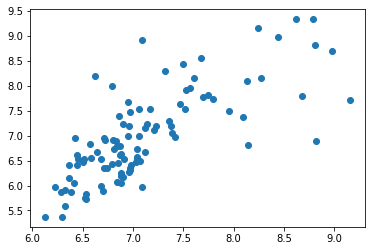

In [49]:
plt.scatter(gm_fold1_cbp_w_bias_pred_cts,
            np.log(np.exp(gm_fold1_cbp_wo_bias_pred_cts)+np.exp(gm_fold1_bias_pred_cts)))

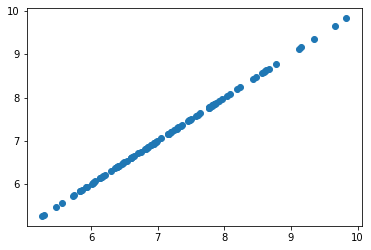

In [50]:
plt.scatter(other_cbp_w_bias_pred_cts,
            np.log(np.exp(other_cbp_wo_bias_pred_cts)+np.exp(other_bias_pred_cts)))